# Traductor ENG → SPA en PyTorch

Basado en [versión Keras](https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/blob/main/clase_6/jupyter_notebooks/tensorflow/6c%20-%20traductor.ipynb) mostrada en clase.

In [1]:
import re
import gdown
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from torch.nn.utils.rnn import pad_sequence
from tqdm.notebook import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {str(device).upper()}")

Using device: CUDA


# Datos


In [3]:
# descarga de datos
if os.access('spa-eng', os.F_OK) is False:
    if os.access('spa-eng.zip', os.F_OK) is False:
        !curl -L -o 'spa-eng.zip' 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip'
    !unzip -q spa-eng.zip
else:
    print("El dataset ya se encuentra descargado")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2576k  100 2576k    0     0  1107k      0  0:00:02  0:00:02 --:--:-- 1107k


In [4]:
# levantamos los datos
data = pd.read_csv('spa-eng/spa.txt',sep='\t', names=['eng','spa'])

data

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
118959,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118960,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118961,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118962,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


In [5]:
data.eng.tail().tolist()

['There are four main causes of alcohol-related death. Injury from car accidents or violence is one. Diseases like cirrhosis of the liver, cancer, heart and blood system diseases are the others.',
 "There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college education.",
 'A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climate change.',
 'Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Google and hope for something less irritating.',
 'If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banj

<Axes: >

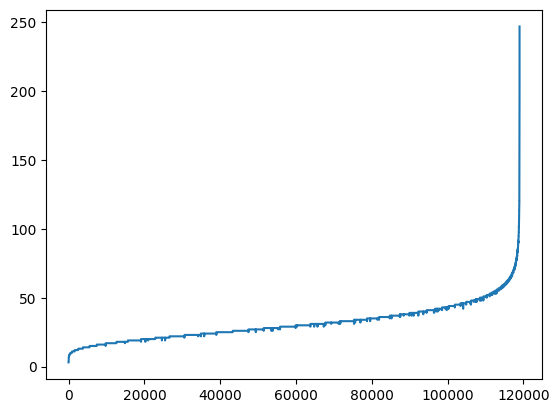

In [6]:
# a ver las longitudes...
data.eng.str.len().plot()

<Axes: xlabel='eng', ylabel='Proportion'>

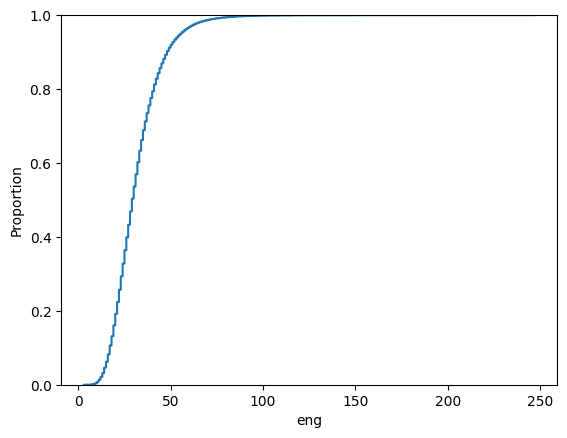

In [7]:
# a ver esa distribución de longitudes, parecen casi outliers los últimos
sns.ecdfplot(data.eng.str.len())

* Están aprox. ordenadas por longitud, por lo que hay que hacer shuffling para romper esto.
* La gran mayoría de las observaciones tienen longitud menor a 100 caracteres, no parece tener mucho sentido soportar secuencias tan largas si son tan raras.

In [8]:
# dropeamos las rows con longitud excesiva
MAX_CHAR_LEN_SEQS = 100

data_truncated_len = data[data.map(len).max(axis=1) <= MAX_CHAR_LEN_SEQS].copy().reset_index(drop=True)

data_truncated_len

,eng,spa
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
118640,I don't quite believe it when I hear someone c...,No termino de creer cuando alguien afirma que ...
118641,If you spend too much time in the sun without ...,Si pasas demasiado tiempo al sol sin ponerte p...
118642,One of the greatest secrets of happiness is mo...,Uno de los grandes secretos de la felicidad es...
118643,That knife wasn't sharp and I couldn't cut the...,Ese cuchillo no estaba afilado y no podía cort...


# Tokenización

In [9]:
FILTERS_SPA = '!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n'
MAX_VOCAB_SIZE = 16000
BOS_TOKEN = '<bos>'
EOS_TOKEN = '<eos>'

In [10]:
tk_in = Tokenizer(num_words=MAX_VOCAB_SIZE)
tk_in.fit_on_texts(data_truncated_len.eng.tolist())

input_indices_seqs = tk_in.texts_to_sequences(data_truncated_len.eng.tolist())

word2idx_in = tk_in.word_index
idx2word_in = {v:k for k,v in word2idx_in.items()}

max_input_len = max(map(len, input_indices_seqs))

print("Palabras en el vocabulario:", len(word2idx_in))
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 13381
Sentencia de entrada más larga: 22


In [11]:
tk_out = Tokenizer(num_words=MAX_VOCAB_SIZE, filters=FILTERS_SPA)
tk_out.fit_on_texts([BOS_TOKEN, EOS_TOKEN]+data_truncated_len.spa.tolist())

output_indices_seqs = tk_out.texts_to_sequences(data_truncated_len.spa.tolist())

word2idx_out = tk_out.word_index
idx2word_out = {v:k for k,v in word2idx_out.items()}

#num_words_out= min(len(word2idx_out) + 1, MAX_VOCAB_SIZE)

print("Palabras en el vocabulario:", len(word2idx_out)+1)
print("Sentencia de entrada más larga:", max(map(len, output_indices_seqs)))

Palabras en el vocabulario: 26104
Sentencia de entrada más larga: 21


In [12]:
# agregamos a todas las secuencias de salida un <BOS> al principio y un <EOS> al final
BOS_IDX = word2idx_out[BOS_TOKEN]
EOS_IDX = word2idx_out[EOS_TOKEN]

output_indices_seq_bos_eos = [[BOS_IDX]+seq+[EOS_IDX] for seq in output_indices_seqs]

In [13]:
# hacemos un split train-valid de 80-20 como en clase, aplicamos shuffling
TEST_SZ = 0.2

train_tokens_in, test_tokens_in, train_tokens_out, test_tokens_out = train_test_split(
    input_indices_seqs,
    output_indices_seq_bos_eos,
    test_size=TEST_SZ,
    shuffle=True,
    random_state=13,
)

# Embeddings

Se utilizan los de fastText

In [14]:
# descarga de embeddings
if not os.path.exists('cc.en.300.vec'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
    !gunzip cc.en.300.vec.gz

if not os.path.exists('cc.es.300.vec'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
    !gunzip cc.es.300.vec.gz

--2025-10-07 15:33:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.123, 13.35.37.111, 13.35.37.84, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   246MB/s    in 5.1s    

2025-10-07 15:33:28 (247 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

--2025-10-07 15:33:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.124, 108.157.254.102, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to:

In [15]:
# nota: GPT-produced

def load_restricted_fasttext_vectors(path, vocab):
    """
    Load FastText vectors from a .vec file, keeping only words in vocab.
    Returns: dict[word] = vector, and vector_dim
    """
    vocab = set(vocab)
    vectors = {}
    dim = None

    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        header = f.readline()
        for line in f:
            parts = line.rstrip().split(' ')
            word = parts[0]
            if word in vocab:
                vec = np.asarray(parts[1:], dtype=np.float32)
                dim = len(vec)
                vectors[word] = vec
    return vectors, dim


def build_embedding_matrix(vocab_size, stoi, vectors, dim):
    """
    Build embedding matrix aligned with vocab indices.
    Missing words get random initialization.
    """
    matrix = np.zeros((vocab_size, dim), dtype=np.float32)
    missing = 0
    for word, idx in stoi.items():
        if word in vectors:
            matrix[idx] = vectors[word]
        else:
            matrix[idx] = np.random.normal(scale=0.6, size=(dim,))
            missing += 1
    print(f"Missing {missing}/{vocab_size} ({missing/vocab_size*100:.1f}%) words")
    return matrix

In [16]:
# levantamos solo los vectores necesarios
eng_vectors, dim_en = load_restricted_fasttext_vectors("cc.en.300.vec", list(word2idx_in.keys()))
spa_vectors, dim_es = load_restricted_fasttext_vectors("cc.es.300.vec", list(word2idx_out.keys()))

In [17]:
# armamos las matrices de embeddings
eng_matrix = build_embedding_matrix(len(word2idx_in)+1, word2idx_in, eng_vectors, dim_en)
spa_matrix = build_embedding_matrix(len(word2idx_out)+1, word2idx_out, spa_vectors, dim_es)

Missing 465/13382 (3.5%) words
Missing 927/26104 (3.6%) words


In [18]:
# generamos los modulos de Pytorch y congelamos los pesos
eng_embedding = nn.Embedding.from_pretrained(torch.tensor(eng_matrix), freeze=True)
spa_embedding = nn.Embedding.from_pretrained(torch.tensor(spa_matrix), freeze=True)

In [19]:
# mostramos dimensiones
for m in (eng_embedding, spa_embedding):
    print(m.weight.shape)

torch.Size([13382, 300])
torch.Size([26104, 300])


# Dataset

In [20]:
# util para hacer padding y conversion
def unify_pad(input: list[list[int]], padding_side: str, dtype=torch.int32) -> torch.Tensor:
    return pad_sequence(
        [torch.tensor(x, dtype=dtype) for x in input],
        padding_side=padding_side,
        batch_first=True
    )

In [21]:
class SeqPairDataset(Dataset):
    def __init__(self, in_seqs, out_seqs, dynamic_truncate=True):
        assert len(in_seqs)==len(out_seqs), "in & out lengths should be the same!"
        self.in_seqs = unify_pad(in_seqs, 'left')
        self.out_seqs = unify_pad(out_seqs, 'right')
        self.dynamic_truncate = dynamic_truncate

    def __len__(self):
        return len(self.in_seqs)

    def __getitem__(self, idx):
        in_seqs = self.in_seqs[idx]
        out_seqs = self.out_seqs[idx]

        if not self.dynamic_truncate:
            return in_seqs, out_seqs

        # si ninguna es max_seq_len, se reduce para ahorrar tiempo
        # Nota: en un array bool, argmax devuelve el primer indice distinto de 0
        # pero no existe argmax para bools entonces hay que pasarlo a byte
        # Caveat: si no hay ninguno, devuelve 0, pero eso se puede evitar...
        # ...pidiendo que haya al menos un True en el array (con un .any())

        ## input
        conds = (in_seqs != 0).any(axis=0)
        if conds.any().item():
            first_non_zero_idx_in = conds.byte().argmax().item()

            if first_non_zero_idx_in > 0:
                in_seqs = in_seqs[:, first_non_zero_idx_in:]

        ## output
        conds = (out_seqs == 0).all(axis=0)
        if conds.any().item():
            first_all_zero_idx_out = conds.byte().argmax().item()

            if first_all_zero_idx_out < (out_seqs.shape[1] - 1):
                out_seqs = out_seqs[:, :first_all_zero_idx_out]

        return in_seqs, out_seqs

In [22]:
train_ds = SeqPairDataset(train_tokens_in, train_tokens_out)
test_ds = SeqPairDataset(test_tokens_in, test_tokens_out)

In [23]:
# mostramos shapes
sample_indices = [0,1,6,7]

for idx in sample_indices:
    print([x.shape for x in train_ds[[idx]]])

print("total:",[x.shape for x in train_ds[sample_indices]])

[torch.Size([1, 3]), torch.Size([1, 6])]
[torch.Size([1, 4]), torch.Size([1, 5])]
[torch.Size([1, 6]), torch.Size([1, 7])]
[torch.Size([1, 15]), torch.Size([1, 13])]
total: [torch.Size([4, 15]), torch.Size([4, 13])]


In [24]:
TRAIN_BATCH_SZ = 512
TEST_BATCH_SZ = 1024

train_dl = DataLoader(
    train_ds,
    batch_size=TRAIN_BATCH_SZ,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

test_dl = DataLoader(
    test_ds,
    batch_size=TEST_BATCH_SZ,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

# Modelo

Separamos en encoder y decoder, observar que el decoder devuelve logits, NO probs (no se aplica softmax).

In [25]:
class Encoder(nn.Module):
    def __init__(self, embedding_matrix, **lstm_args):
        super().__init__()

        self.embeddings = embedding_matrix

        # nos aseguramos que esté freezeada
        self.embeddings.weight.requires_grad = False

        # para que sea mas claro
        embed_dim = embedding_matrix.embedding_dim
        vocab_size = embedding_matrix.num_embeddings

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            batch_first=True,
            **lstm_args
        )

    def forward(self, input_tokens):
        embeddings = self.embeddings(input_tokens)

        # descartamos el output
        _ , state = self.lstm(embeddings)

        return state

In [51]:
class Decoder(nn.Module):
    def __init__(self, embedding_matrix, head=None, **lstm_args):
        super().__init__()

        self.embeddings = embedding_matrix

        # nos aseguramos que esté freezeada
        self.embeddings.weight.requires_grad = False

        # para que sea mas claro
        embed_dim = embedding_matrix.embedding_dim
        vocab_size = embedding_matrix.num_embeddings

        # embeddings -> state
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            batch_first=True,
            **lstm_args
        )

        # state -> indice del token
        self.head = nn.Linear(self.lstm.hidden_size, vocab_size) if head is None else head

    def forward(self, input_tokens, prev_state, last_only=False):
        embeddings = self.embeddings(input_tokens)

        lstm_out, state = self.lstm(embeddings, prev_state)

        if last_only:
            lstm_out = lstm_out[:,-1,:] if lstm_out.ndim == 3 else lstm_out[-1,:]

        head_out = self.head(lstm_out)

        return head_out, state

In [52]:
# training util
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_tokens, output_tokens):

        # encoder last state
        encoder_state = self.encoder(input_tokens)

        # teacher forcing para training, se asume que <BOS> and <EOS> ya están:
        decoder_input = output_tokens[:,:-1]

        # al decoder le hacemos un forward sin last_only
        logits, _ = self.decoder(decoder_input, encoder_state, False)

        return logits

Instanciamos uno para mostrar

In [28]:
lstm_args = dict(
    hidden_size = 128,      # LSTM WIDTH
    num_layers = 1,         # N LAYERS
)

enc1 = Encoder(
    eng_embedding,
    **lstm_args
)

dec1 = Decoder(
    spa_embedding,
    **lstm_args
)

s2s_1 = Seq2Seq(enc1,dec1).to(device)
s2s_1

Seq2Seq(
  (encoder): Encoder(
    (embeddings): Embedding(13382, 300)
    (lstm): LSTM(300, 128, batch_first=True)
  )
  (decoder): Decoder(
    (embeddings): Embedding(26104, 300)
    (lstm): LSTM(300, 128, batch_first=True)
    (head): Linear(in_features=128, out_features=26104, bias=True)
  )
)

Mostramos uso

In [29]:
sample_indices = [0,1,25]

sample_in, sample_out = train_ds[sample_indices]

sample_in.shape, sample_out.shape

(torch.Size([3, 8]), torch.Size([3, 9]))

In [30]:
# pasamos por el modelo
res = s2s_1(sample_in.to(device), sample_out.to(device)).cpu()
res.shape

torch.Size([3, 8, 26104])

Como se observa, la salida es de forma `(batch_sz, output_seq_len - 1, out_vocab_sz)`

In [31]:
# tomamos el argmax por vocab
res.max(dim=-1).indices.shape

torch.Size([3, 8])

In [32]:
res.size(-1)

26104

# Train

In [33]:
# util
def eval_model(model, test_dataloader, device):
    model.eval()
    with torch.no_grad():
        total_tokens = 0
        total_loss = 0.0
        total_correct = 0

        for batch_input_tokens, batch_output_tokens in test_dataloader:
            # omit <BOS>
            expected_output_tokens = batch_output_tokens[:,1:]

            # predict
            logits = model(
                batch_input_tokens.to(device),
                batch_output_tokens.to(device)
            )

            # cross entropy por token
            loss = F.cross_entropy(
                logits.reshape(-1, logits.shape[-1]),
                expected_output_tokens.reshape(-1).long().to(device),
                ignore_index=0, # omitir padding
                reduction='sum'
            ).cpu()

            mask = expected_output_tokens != 0
            total_loss += loss.item()
            total_tokens += mask.sum().item()
            total_correct += ((logits.argmax(dim=-1).cpu() == expected_output_tokens) & mask).sum().item()

    return dict(
        valid_loss= total_loss / total_tokens,
        valid_acc= total_correct / total_tokens
    )

# mostramos uso
eval_model(s2s_1, test_dl, device)

{'valid_loss': 10.176859218735816, 'valid_acc': 6.051986564589827e-06}

In [34]:
# borramos el modelo
del s2s_1
gc.collect()
torch.cuda.empty_cache()

In [35]:
# utils
def train_one_epoch(model, optimizer, train_dl, device):
    total_tokens = 0
    total_loss = 0.0

    for batch_input_tokens, batch_output_tokens in train_dl:
        # reset de gradientes
        optimizer.zero_grad()

        # omit <BOS>
        expected_output_tokens = batch_output_tokens[:,1:].long().to(device)

        # predict
        logits = model(
            batch_input_tokens.to(device),
            batch_output_tokens.to(device)
        )

        # cross entropy por token
        loss = F.cross_entropy(
            logits.reshape(-1, logits.shape[-1]),
            expected_output_tokens.reshape(-1),
            ignore_index=0, # omitir padding
            reduction='sum'
        )

        valid_tokens = (expected_output_tokens != 0).sum().item()
        batch_loss = loss / valid_tokens

        batch_loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_tokens += valid_tokens

    return dict(
        train_loss= total_loss / total_tokens
    )

In [36]:
# utils
def train(model, optimizer, train_dl, test_dl, device, epochs, patience, save_name, save_min_acc=0.0):
    saved_ckp = False
    best_val = 999
    cur_patience = patience
    historics = []
    fname = f"{save_name}.pt"
    for epoch in tqdm(range(epochs),total=epochs):
        model.train()
        train_stats = train_one_epoch(model, optimizer, train_dl, device)
        valid_stats = eval_model(model, test_dl, device)
        print(f"Epoch {epoch+1:>3}/{epochs:>3}: "
              f"train_loss={train_stats['train_loss']:.3f}, "
              f"valid_loss={valid_stats['valid_loss']:.3f}, "
              f"valid_acc={valid_stats['valid_acc']:.3f}")
        historics.append(train_stats | valid_stats)

        if valid_stats['valid_loss'] < best_val:
            print(f"New best at epoch {epoch+1}")
            cur_patience = patience
            best_val = valid_stats['valid_loss']

            if valid_stats['valid_acc'] > save_min_acc:
                torch.save(model.state_dict(), fname)
                print(f"Saved checkpoint at", fname)
                saved_ckp = True

        else:
            cur_patience -= 1
            if cur_patience < 0:
                print(f"Breaking due to exhausted patience at epoch {epoch+1}")
                break

    # if never saved, save once
    if not saved_ckp:
        torch.save(model.state_dict(), fname)
        print(f"Saving final result at", fname)

    return pd.DataFrame(historics)

In [53]:
# un util más para iterar rápido
def run_experiment(lstm_cfg, optim_cfg, dataloaders, device, epochs, patience, name, save_min_acc=0, decoder_head=None):
    train_dl, test_dl = dataloaders

    model = Seq2Seq(
        encoder = Encoder(eng_embedding, **lstm_cfg),
        decoder = Decoder(spa_embedding, head=decoder_head, **lstm_cfg)
    ).to(device)

    opt = optim.Adam(
        [p for p in model.parameters() if p.requires_grad],
        **optim_cfg,
    )

    result = train(model, opt, train_dl, test_dl, device, epochs, patience, name, save_min_acc)

    # borramos el modelo, si hace falta lo levantamos
    del model, opt
    gc.collect()
    torch.cuda.empty_cache()

    return dict(
        name = name,
        results = result,
    )

## Experimentos

### Baseline

In [38]:
# baseline
baseline = run_experiment(
    lstm_cfg=dict(hidden_size = 128, num_layers = 1),
    optim_cfg=dict(lr=1e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=30,
    patience=4,
    name='baseline',
    save_min_acc=0.5
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch   1/ 30: train_loss=6.407, valid_loss=5.818, valid_acc=0.177
New best at epoch 1
Epoch   2/ 30: train_loss=5.626, valid_loss=5.459, valid_acc=0.201
New best at epoch 2
Epoch   3/ 30: train_loss=5.266, valid_loss=5.112, valid_acc=0.238
New best at epoch 3
Epoch   4/ 30: train_loss=4.919, valid_loss=4.803, valid_acc=0.267
New best at epoch 4
Epoch   5/ 30: train_loss=4.629, valid_loss=4.558, valid_acc=0.290
New best at epoch 5
Epoch   6/ 30: train_loss=4.396, valid_loss=4.361, valid_acc=0.307
New best at epoch 6
Epoch   7/ 30: train_loss=4.202, valid_loss=4.201, valid_acc=0.321
New best at epoch 7
Epoch   8/ 30: train_loss=4.034, valid_loss=4.055, valid_acc=0.332
New best at epoch 8
Epoch   9/ 30: train_loss=3.888, valid_loss=3.928, valid_acc=0.345
New best at epoch 9
Epoch  10/ 30: train_loss=3.751, valid_loss=3.818, valid_acc=0.357
New best at epoch 10
Epoch  11/ 30: train_loss=3.624, valid_loss=3.702, valid_acc=0.370
New best at epoch 11
Epoch  12/ 30: train_loss=3.501, valid_lo

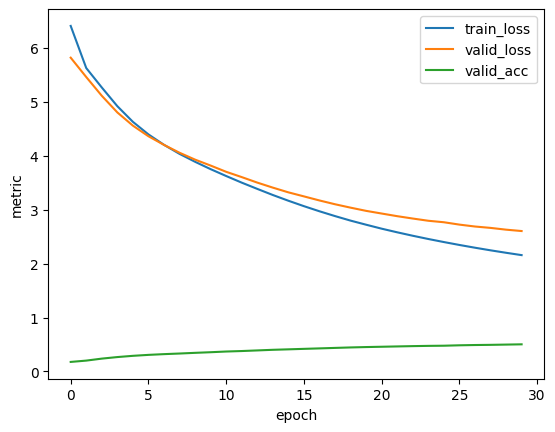

In [39]:
ax = baseline['results'].plot(xlabel='epoch', ylabel='metric')
plt.show()

El resultado es bueno, probablemente mejoraría un poco más con un entrenamiento más largo pero tampoco tanto. Probamos con una variante más ancha y una variante más profunda para comparar. Usamos runs más cortos para ver si son esquemas prometedores.

### Más neuronas por capa recurrente

In [40]:
# 2x ancho
wider = run_experiment(
    lstm_cfg=dict(hidden_size = 256, num_layers = 1),
    optim_cfg=dict(lr=1e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='wider',
    save_min_acc=0.6
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=6.190, valid_loss=5.655, valid_acc=0.189
New best at epoch 1
Epoch   2/ 10: train_loss=5.311, valid_loss=5.005, valid_acc=0.252
New best at epoch 2
Epoch   3/ 10: train_loss=4.725, valid_loss=4.543, valid_acc=0.292
New best at epoch 3
Epoch   4/ 10: train_loss=4.310, valid_loss=4.213, valid_acc=0.320
New best at epoch 4
Epoch   5/ 10: train_loss=3.994, valid_loss=3.949, valid_acc=0.346
New best at epoch 5
Epoch   6/ 10: train_loss=3.729, valid_loss=3.732, valid_acc=0.368
New best at epoch 6
Epoch   7/ 10: train_loss=3.501, valid_loss=3.541, valid_acc=0.389
New best at epoch 7
Epoch   8/ 10: train_loss=3.298, valid_loss=3.384, valid_acc=0.403
New best at epoch 8
Epoch   9/ 10: train_loss=3.114, valid_loss=3.233, valid_acc=0.422
New best at epoch 9
Epoch  10/ 10: train_loss=2.948, valid_loss=3.107, valid_acc=0.436
New best at epoch 10
Saving final result at wider.pt


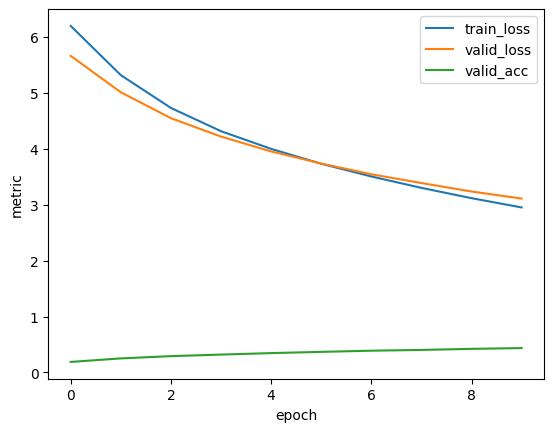

In [41]:
ax = wider['results'].plot(xlabel='epoch', ylabel='metric')
plt.show()

### Más capas

In [42]:
deeper = run_experiment(
    lstm_cfg=dict(hidden_size = 128, num_layers = 2),
    optim_cfg=dict(lr=1e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='deeper',
    save_min_acc=0.6
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=6.389, valid_loss=5.866, valid_acc=0.174
New best at epoch 1
Epoch   2/ 10: train_loss=5.761, valid_loss=5.671, valid_acc=0.199
New best at epoch 2
Epoch   3/ 10: train_loss=5.499, valid_loss=5.330, valid_acc=0.228
New best at epoch 3
Epoch   4/ 10: train_loss=5.106, valid_loss=4.948, valid_acc=0.258
New best at epoch 4
Epoch   5/ 10: train_loss=4.746, valid_loss=4.637, valid_acc=0.284
New best at epoch 5
Epoch   6/ 10: train_loss=4.443, valid_loss=4.371, valid_acc=0.311
New best at epoch 6
Epoch   7/ 10: train_loss=4.191, valid_loss=4.155, valid_acc=0.336
New best at epoch 7
Epoch   8/ 10: train_loss=3.972, valid_loss=3.963, valid_acc=0.354
New best at epoch 8
Epoch   9/ 10: train_loss=3.775, valid_loss=3.789, valid_acc=0.371
New best at epoch 9
Epoch  10/ 10: train_loss=3.596, valid_loss=3.644, valid_acc=0.387
New best at epoch 10
Saving final result at deeper.pt


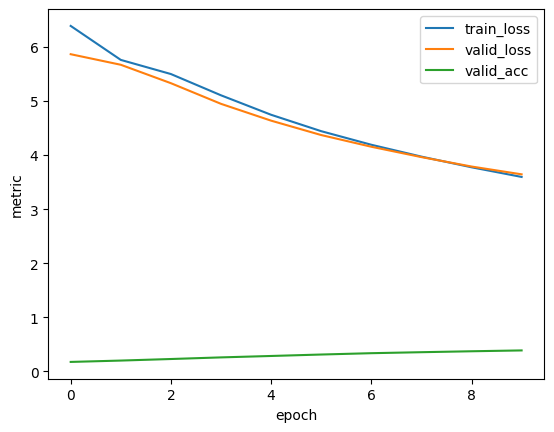

In [43]:
ax = deeper['results'].plot(xlabel='epoch', ylabel='metric')
plt.show()

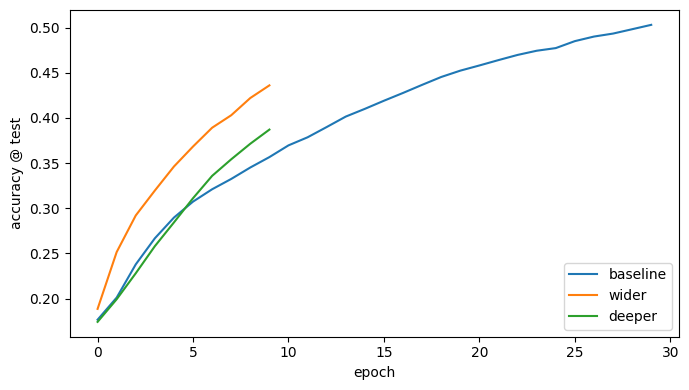

In [44]:
# comparamos valid_acc de los 3
fig, ax = plt.subplots(figsize=(7,4))
for res in (baseline, wider, deeper):
    ax.plot(res['results']['valid_acc'], label=res['name'])
ax.set_ylabel('accuracy @ test')
ax.set_xlabel('epoch')
plt.legend(loc='lower right')
plt.tight_layout()

* Ninguna de las 3 variantes cayó en overfitting, aunque es verdad que solo el baseline se entrenó por 30 epochs, las otras solo por 10.
* Definitivamente un mayor ancho mejora la performance. Aún así se debe tener en cuenta que la dimensión de embeddings es 300, por lo que más de 256 (usando potencias de 2) ya la excede.
* Mayor profundidad no pareciera mejorar, aunque sí se observa una curva más pronunciada.

Se prueba con más ancho y más profundidad. Si overfittea, agregamos dropout.

In [45]:
wider_deeper = run_experiment(
    lstm_cfg=dict(hidden_size = 256, num_layers = 2),
    optim_cfg=dict(lr=1e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='wider_deeper',
    save_min_acc=0.6
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=6.210, valid_loss=5.828, valid_acc=0.183
New best at epoch 1
Epoch   2/ 10: train_loss=5.654, valid_loss=5.475, valid_acc=0.218
New best at epoch 2
Epoch   3/ 10: train_loss=5.211, valid_loss=4.988, valid_acc=0.259
New best at epoch 3
Epoch   4/ 10: train_loss=4.708, valid_loss=4.520, valid_acc=0.305
New best at epoch 4
Epoch   5/ 10: train_loss=4.250, valid_loss=4.139, valid_acc=0.337
New best at epoch 5
Epoch   6/ 10: train_loss=3.882, valid_loss=3.826, valid_acc=0.369
New best at epoch 6
Epoch   7/ 10: train_loss=3.578, valid_loss=3.572, valid_acc=0.397
New best at epoch 7
Epoch   8/ 10: train_loss=3.317, valid_loss=3.365, valid_acc=0.416
New best at epoch 8
Epoch   9/ 10: train_loss=3.089, valid_loss=3.187, valid_acc=0.436
New best at epoch 9
Epoch  10/ 10: train_loss=2.891, valid_loss=3.031, valid_acc=0.454
New best at epoch 10
Saving final result at wider_deeper.pt


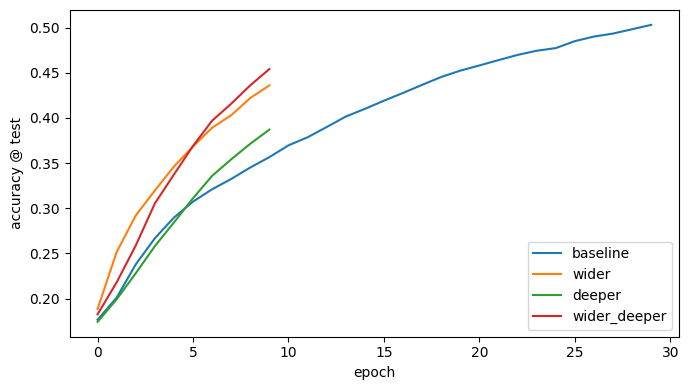

In [46]:
fig, ax = plt.subplots(figsize=(7,4))
for res in (baseline, wider, deeper, wider_deeper):
    ax.plot(res['results']['valid_acc'], label=res['name'])
ax.set_ylabel('accuracy @ test')
ax.set_xlabel('epoch')
plt.legend(loc='lower right')
plt.tight_layout()

Efectivamente mejora, aprende más rápido (como wider) y la curva es más pronunciada (como deeper). Probamos con más learning rate a ver si lo tolera, luego pasamos a más ancho y profundidad.

In [47]:
wd_lr_x5 = run_experiment(
    lstm_cfg=dict(hidden_size = 256, num_layers = 2),
    optim_cfg=dict(lr=5e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='wd_lr_x5',
    save_min_acc=0.6
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=6.099, valid_loss=5.747, valid_acc=0.188
New best at epoch 1
Epoch   2/ 10: train_loss=5.319, valid_loss=4.863, valid_acc=0.261
New best at epoch 2
Epoch   3/ 10: train_loss=4.320, valid_loss=3.935, valid_acc=0.348
New best at epoch 3
Epoch   4/ 10: train_loss=3.511, valid_loss=3.322, valid_acc=0.416
New best at epoch 4
Epoch   5/ 10: train_loss=2.941, valid_loss=2.948, valid_acc=0.462
New best at epoch 5
Epoch   6/ 10: train_loss=2.522, valid_loss=2.684, valid_acc=0.499
New best at epoch 6
Epoch   7/ 10: train_loss=2.194, valid_loss=2.496, valid_acc=0.529
New best at epoch 7
Epoch   8/ 10: train_loss=1.935, valid_loss=2.377, valid_acc=0.547
New best at epoch 8
Epoch   9/ 10: train_loss=1.725, valid_loss=2.300, valid_acc=0.561
New best at epoch 9
Epoch  10/ 10: train_loss=1.554, valid_loss=2.245, valid_acc=0.573
New best at epoch 10
Saving final result at wd_lr_x5.pt


Mejoró mucho, aunque es verdad que estamos usando un batch size grande y los modelos son bastante "shallow".

In [48]:
# wider-deeper con 2x width
w2d = run_experiment(
    lstm_cfg=dict(hidden_size = 512, num_layers = 2),
    optim_cfg=dict(lr=5e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='w2d',
    save_min_acc=1
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=5.612, valid_loss=4.852, valid_acc=0.222
New best at epoch 1
Epoch   2/ 10: train_loss=4.421, valid_loss=4.218, valid_acc=0.283
New best at epoch 2
Epoch   3/ 10: train_loss=3.750, valid_loss=3.702, valid_acc=0.345
New best at epoch 3
Epoch   4/ 10: train_loss=3.168, valid_loss=3.331, valid_acc=0.402
New best at epoch 4
Epoch   5/ 10: train_loss=2.706, valid_loss=3.102, valid_acc=0.436
New best at epoch 5
Epoch   6/ 10: train_loss=2.350, valid_loss=2.949, valid_acc=0.462
New best at epoch 6
Epoch   7/ 10: train_loss=2.059, valid_loss=2.863, valid_acc=0.482
New best at epoch 7
Epoch   8/ 10: train_loss=1.819, valid_loss=2.825, valid_acc=0.492
New best at epoch 8
Epoch   9/ 10: train_loss=1.619, valid_loss=2.814, valid_acc=0.502
New best at epoch 9
Epoch  10/ 10: train_loss=1.452, valid_loss=2.814, valid_acc=0.508
Saving final result at w2d.pt


In [49]:
# wider-deeper con 2x depth
wd2 = run_experiment(
    lstm_cfg=dict(hidden_size = 256, num_layers = 3),
    optim_cfg=dict(lr=5e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='wd2',
    save_min_acc=1
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=6.191, valid_loss=5.984, valid_acc=0.173
New best at epoch 1
Epoch   2/ 10: train_loss=5.555, valid_loss=5.050, valid_acc=0.224
New best at epoch 2
Epoch   3/ 10: train_loss=4.527, valid_loss=4.218, valid_acc=0.300
New best at epoch 3
Epoch   4/ 10: train_loss=3.870, valid_loss=3.752, valid_acc=0.354
New best at epoch 4
Epoch   5/ 10: train_loss=3.402, valid_loss=3.410, valid_acc=0.396
New best at epoch 5
Epoch   6/ 10: train_loss=3.015, valid_loss=3.144, valid_acc=0.432
New best at epoch 6
Epoch   7/ 10: train_loss=2.708, valid_loss=2.958, valid_acc=0.459
New best at epoch 7
Epoch   8/ 10: train_loss=2.453, valid_loss=2.829, valid_acc=0.479
New best at epoch 8
Epoch   9/ 10: train_loss=2.241, valid_loss=2.721, valid_acc=0.498
New best at epoch 9
Epoch  10/ 10: train_loss=2.058, valid_loss=2.651, valid_acc=0.510
New best at epoch 10
Saving final result at wd2.pt


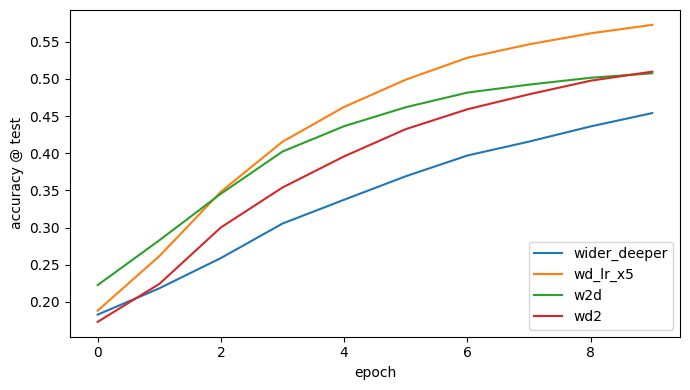

In [50]:
fig, ax = plt.subplots(figsize=(7,4))
for res in (wider_deeper, wd_lr_x5, w2d, wd2):
    ax.plot(res['results']['valid_acc'], label=res['name'])
ax.set_ylabel('accuracy @ test')
ax.set_xlabel('epoch')
plt.legend(loc='lower right')
plt.tight_layout()

* Agregar una capa más no pareció mejorar.
* Duplicar la cantidad de neuronas por capa mejora, pero a costo de enlentecer mucho cada epoch.
* Aumentar el learning rate fue muy productivo, pero al escalar más los modelos (w2d y wd2) parece que 5e-3 es mucho.

Se está volviendo muy lento cada experimento. No se muestra en esta versión del notebook, pero se probaron combinaciones de mayor ancho y/o mayor profundidad sobre test runs de 10 epochs. Las conclusiones fueron:

* Al aumentar la escala hace falta volver a bajar el learning rate, sino no logra aprender. Probablemente requiriese un scheduler.
* Dropout no ayuda porque no hay overfitting.
* Aumentar el ancho sigue aportando, pero también es el principal factor de aumento en tiempo de entrenamiento: para 10 epochs y 2 capas, hidden_size de 512 son 15 minutos, si pasa a 768 son 25.
* Aumentar la cantidad de capas no parece mejorar mucho, al menos en los primeros epochs. Probablemente tenga un máximo "asintótico" más alto, i.e. tarda más en aprender pero termina absorbiendo más información.
* Las mejoras en ningún caso eran significativas respecto de `w2d` a 10 epochs, pero sí los runs eran mucho más lentos.

Antes de seguir, probamos con agrandar el head como forma de "aprovechar mejor" la información comprimida en las capas recurrentes. Por supuesto, ello implica un aumento enorme en la cantidad de parámetros entrenables.

In [55]:
# armamos head especial, usando el típico 2-layer MLP block

cfg = dict(hidden_size = 256, num_layers = 2)
interm_sz = 2048
dec_head = nn.Sequential(
    nn.Linear(cfg['hidden_size'], interm_sz),
    nn.ReLU(),
    nn.Linear(interm_sz, spa_embedding.num_embeddings)
)

head2 = run_experiment(
    lstm_cfg=cfg,
    decoder_head=dec_head,
    optim_cfg=dict(lr=2e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=10,
    patience=4,
    name='head2',
    save_min_acc=1
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch   1/ 10: train_loss=5.550, valid_loss=4.575, valid_acc=0.282
New best at epoch 1
Epoch   2/ 10: train_loss=3.918, valid_loss=3.494, valid_acc=0.392
New best at epoch 2
Epoch   3/ 10: train_loss=2.910, valid_loss=2.865, valid_acc=0.475
New best at epoch 3
Epoch   4/ 10: train_loss=2.203, valid_loss=2.531, valid_acc=0.530
New best at epoch 4
Epoch   5/ 10: train_loss=1.722, valid_loss=2.406, valid_acc=0.562
New best at epoch 5
Epoch   6/ 10: train_loss=1.383, valid_loss=2.365, valid_acc=0.582
New best at epoch 6
Epoch   7/ 10: train_loss=1.143, valid_loss=2.381, valid_acc=0.593
Epoch   8/ 10: train_loss=0.962, valid_loss=2.479, valid_acc=0.603
Epoch   9/ 10: train_loss=0.820, valid_loss=2.497, valid_acc=0.607
Epoch  10/ 10: train_loss=0.708, valid_loss=2.576, valid_acc=0.609
Saving final result at head2.pt


Si bien tiene resultados prometedores, en términos de tiempo tardó mucho más en obtener la misma performance que wd con learning rate aumentado.

In [56]:
gc.collect()
torch.cuda.empty_cache()

Hacemos un run "largo" con wd-lr5

In [57]:
wd_lr5_longer = run_experiment(
    lstm_cfg=dict(hidden_size = 256, num_layers = 2),
    optim_cfg=dict(lr=5e-3),
    dataloaders=(train_dl, test_dl),
    device=device,
    epochs=30,
    patience=4,
    name='wd_lr5_longer',
    save_min_acc=0.6
)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch   1/ 30: train_loss=5.957, valid_loss=5.377, valid_acc=0.225
New best at epoch 1
Epoch   2/ 30: train_loss=4.765, valid_loss=4.238, valid_acc=0.317
New best at epoch 2
Epoch   3/ 30: train_loss=3.747, valid_loss=3.456, valid_acc=0.401
New best at epoch 3
Epoch   4/ 30: train_loss=3.040, valid_loss=2.987, valid_acc=0.458
New best at epoch 4
Epoch   5/ 30: train_loss=2.536, valid_loss=2.650, valid_acc=0.502
New best at epoch 5
Epoch   6/ 30: train_loss=2.163, valid_loss=2.445, valid_acc=0.533
New best at epoch 6
Epoch   7/ 30: train_loss=1.882, valid_loss=2.321, valid_acc=0.553
New best at epoch 7
Epoch   8/ 30: train_loss=1.662, valid_loss=2.239, valid_acc=0.569
New best at epoch 8
Epoch   9/ 30: train_loss=1.481, valid_loss=2.192, valid_acc=0.578
New best at epoch 9
Epoch  10/ 30: train_loss=1.332, valid_loss=2.164, valid_acc=0.587
New best at epoch 10
Epoch  11/ 30: train_loss=1.206, valid_loss=2.155, valid_acc=0.592
New best at epoch 11
Epoch  12/ 30: train_loss=1.096, valid_lo

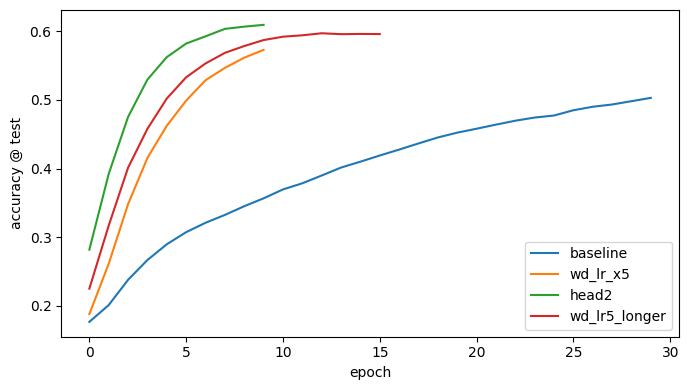

In [59]:
fig, ax = plt.subplots(figsize=(7,4))
for res in (baseline, wd_lr_x5, head2, wd_lr5_longer):
    ax.plot(res['results']['valid_acc'], label=res['name'])
ax.set_ylabel('accuracy @ test')
ax.set_xlabel('epoch')
plt.legend(loc='lower right')
plt.tight_layout()

In [62]:
# lo volvemos a levantar, seteamos en eval y mandamos a device
name = 'wd_lr5_longer'
lstm_cfg = dict(hidden_size = 256, num_layers = 2)

model = Seq2Seq(
        encoder = Encoder(eng_embedding, **lstm_cfg),
        decoder = Decoder(spa_embedding, **lstm_cfg)
)

model.load_state_dict(torch.load(f"{name}.pt", weights_only=True))
model.to(device)
model.eval()
model

Seq2Seq(
  (encoder): Encoder(
    (embeddings): Embedding(13382, 300)
    (lstm): LSTM(300, 256, num_layers=2, batch_first=True)
  )
  (decoder): Decoder(
    (embeddings): Embedding(26104, 300)
    (lstm): LSTM(300, 256, num_layers=2, batch_first=True)
    (head): Linear(in_features=256, out_features=26104, bias=True)
  )
)

# Generación de secuencias

In [186]:
class Translator:
    def __init__(self, encoder, decoder,
                 max_seq_len_in, max_seq_len_out,
                 tokenizer_in, idx2word_out,
                 bos_idx, eos_idx,
                 top_p=0.9, temp=1.0, top_k=1000):
        self.encoder = encoder
        self.decoder = decoder
        self.top_p = top_p
        self.top_k = top_k
        self.temp = temp
        self.max_seq_len_in = max_seq_len_in
        self.max_seq_len_out = max_seq_len_out
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.tk_in = tokenizer_in
        self.idx2word_out = idx2word_out

    def tokenize_in(self, text_in: str) -> torch.Tensor:
        tokens_in = self.tk_in.texts_to_sequences([text_in])[0]
        return torch.tensor(tokens_in[:self.max_seq_len_in], dtype=int, device=device)

    def detokenize_out(self, tokens_in: list[int]) -> str:
        return " ".join(self.idx2word_out[idx] for idx in tokens_in)

    def generate(self, input: torch.Tensor):
        with torch.no_grad():
            output_idx = self.bos_idx
            prev_state = self.encoder(input.to(device))

            output_seq = []

            while len(output_seq) < self.max_seq_len_out:
                logits, prev_state = self.decoder(torch.tensor([output_idx], dtype=int, device=device), prev_state)

                # flatten logits
                logits = logits.flatten()

                values, indices = torch.topk(logits, k=self.top_k)

                probs = F.softmax(values / self.temp, dim=-1)

                cutoff = 1 + torch.searchsorted(probs.cumsum(dim=-1), self.top_p)

                top_p_probs = probs[:cutoff] / probs[:cutoff].sum()

                output_idx = indices[torch.multinomial(top_p_probs,1)].item()

                if output_idx == self.eos_idx:
                    break

                output_seq.append(output_idx)

        return output_seq

    def translate(self, text: str) -> str:
        tokens_in = self.tokenize_in(text)

        tokens_out = self.generate(tokens_in)

        return self.detokenize_out(tokens_out)

In [203]:
trl = Translator(
    encoder=model.encoder,
    decoder=model.decoder,
    max_seq_len_in=max(map(len, input_indices_seqs)),
    max_seq_len_out=max(map(len, output_indices_seqs)),
    tokenizer_in=tk_in,
    idx2word_out=idx2word_out,
    bos_idx=BOS_IDX,
    eos_idx=EOS_IDX,
    top_p=0.9,
    temp=1,
    top_k=500
)

Generamos varios sampleos para cada oración

### Ejemplo 1

In [204]:
INPUT_SEQ = 'my name is pablo'
N_SEQS = 5

for n in range(N_SEQS):
    print(trl.translate(INPUT_SEQ))

mi nombre es
mi nombre es
mi nombre es suyo
mi nombre es
mi nombre es


No sabe la palabra "pablo", pero el resto en general lo traduce bien.

### Ejemplo 2

In [205]:
INPUT_SEQ = 'i like playing tennis'
N_SEQS = 5

for n in range(N_SEQS):
    print(trl.translate(INPUT_SEQ))

me gusta jugar al tenis
me gusta jugar al tenis
me gusta tocar el tenis
me gusta jugar al tenis
me gusta jugar al tenis


En general traduce bien la oración.

### Ejemplo 3

In [208]:
INPUT_SEQ = 'roses are red, violets are blue'
N_SEQS = 5

for n in range(N_SEQS):
    print(trl.translate(INPUT_SEQ))

los rojas son rojos son rojos
tu sol es blanco o las amarillas
los nuevos rojos son rojas de las plantas
las rosas rojas son azules
los rojas son rojos de sol son rojos


Traduce parcialmente bien la oración. Debe tenerse en cuenta que al eliminar las comas, pierde capacidad de interpretar en base a puntuación. En el ejemplo, "roses are red violets" es una subfrase muy confusa.

### Ejemplo 4

In [213]:
INPUT_SEQ = 'i have a black dog and an orange cat'
N_SEQS = 5

for n in range(N_SEQS):
    print(trl.translate(INPUT_SEQ))

tengo un perro de blanco porque ratones de gato
tengo un gato rojo y éste es gato
tengo un perro negro como un gato vivo
tengo un perro negro y que se asemeja a un gato
tengo un perro blanco o negro como gato


Nuevamente traduce parcialmente bien la oración.

### Ejemplo 5

In [219]:
INPUT_SEQ = 'this should be a pretty hard-to-translate sentence considering how long it is'
N_SEQS = 10

for n in range(N_SEQS):
    print(trl.translate(INPUT_SEQ))

este tiene un preciosa sencillo pero no te ayudó a ver a ser famoso que sea bueno
el papel es una manera interesante pero se puede sonar mejor a veces de la naturaleza
este es una tradición difícil pero al saber no sabes más bueno con la manera
es una difícil servir una buena medicina no sabía leer bueno como el tiempo puede estar fácil
esta es una forma preciosa en inglés no todos lo normal como puede entender
este proyecto es un largo esfuerzo pero para reconocer el mundo podría aprender este bien
la primera es una tradición difícil por qué siempre puedes a aprender bastante
este momento es un caro poder pero al menos cualquier el buen modo pueda entender la literatura
no es un bueno para ver a lo famoso en su compañía de matemáticas nunca hay buena importancia
para ese papel es bueno pero para ser bueno para ser difícil que la historia


Como era de esperarse, esta oración la traduce mal. Aún así, en algunos casos logra capturar parte de su significado.

# Conclusiones

Se entrenaron diferentes variantes de modelos de traducción inglés → español utilizando arquitectura seq2seq con redes recurrentes (LSTM) y embeddings preentrenados de fastText.

Se observó como específicamente el ancho de las capas de LSTM es crucial para lograr capturar el significado de las palabras. También, se observó que es un problema difícil, donde resulta complicado llegar al overfitting y la mayoría de los modelos se saturaban antes. Por otra parte, agrandar el *head* del decoder parece ser una buena vía para aumentar la complejidad, pero debe recordarse que esto es a través de aumentar mucho la cantidad de parámetros.

Finalmente, se implementó un traductor basado en el modelo seleccionado, con resultados relativamente satisfactorios. Se utilizó una estrategia de sampling estocástica con top-k, top-p y temperatura ajustable.

Durante la generación de ejemplos se evidenció una de las mayores limitaciones que tiene este approach, que no son las capas recurrentes sino la tokenización por palabras. Esto se condice con las estrategias de tokenización en modelos modernos que utilizan sub-words (fragmentos de palabra).